In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# model = models.resnet18(pretrained=True)
# model.eval();

/Users/alpayozkan/eth/dl_proj


/Users/alpayozkan/opt/anaconda3/envs/ex4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# USE CNN that is pretrained on cifar10
from cifar10_models.resnet import *

model = resnet18()
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Check labels of class

In [3]:
# import urllib
# import ast

# # The URL which has stored the categories of ImageNet
# url_class = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

# # Load the classes and store them as a list
# labels = []
# for line in urllib.request.urlopen(url_class):
#   txt = line.decode('utf-8')
#   # Clean the string
#   label = ''.join([i for i in txt if not i.isdigit() and i != ':' and i != ','])
#   labels.append(label.strip())

# print('We have', len(labels), 'classes')

# # That's the Toucan label
# true_label = 500
# print(str(true_label) + '-th label is', labels[true_label])

We have 1000 classes
500-th label is 'cliff dwelling'


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    # transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


# Our Classmaximization Method (with gaussian blur)

In [9]:
# 

In [5]:
class ClassMaxim(nn.Module):
    def __init__(self):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(1, 3, 32, 32))  
        self.clone = self.x_c.clone()

In [6]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [37]:
clsmax = ClassMaxim()
clss = 9 # billard class

# hyperparameters
lamb = 0.1
lr = 4
sigma = 0.5
kern_size = 3
blur_frequency = 4

In [38]:
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

<Figure size 640x480 with 0 Axes>

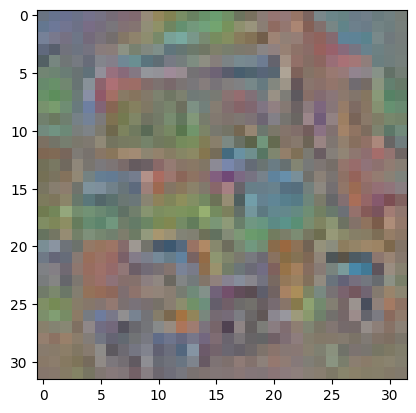

In [39]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)

plt.figure()
for i in range(40):
    # lr-=2
    # if lr <= 8:
    #     lr = 8
    plt.imshow((clsmax.x_c[0]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(20):
        xx = clsmax.x_c[0]
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        loss = (preds[clss] - lamb*(torch.norm(clsmax.x_c[0],p=2)))
        (loss).backward()
        
        grad = clsmax.x_c.grad #/ (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent

        with torch.no_grad():
            # normalize between 0 and 1
            min_value = torch.min(clsmax.x_c)
            max_value = torch.max(clsmax.x_c)
            normalized_tensor = (clsmax.x_c - min_value) / (max_value - min_value)
            blurred_tensor = normalized_tensor

            # Gaussian blur
            if step % blur_frequency == 0:
                blurred_tensor = gaussian_blur_channelwise(normalized_tensor, kernel_size=kern_size, sigma=sigma)
            
            # clipping pixels with small norm
            clipped_tensor = blurred_tensor
            norms = torch.norm(blurred_tensor, dim=1, p=2)
            below_threshold = norms < 0.001
            blurred_tensor[:, :, below_threshold.squeeze(0)] = 0
            clsmax.x_c = nn.Parameter(clipped_tensor  * (max_value - min_value) + min_value)
    
    if(i < 39):
        clear_output(wait=True)
        display(plt.gcf())
